# Full-frame dynamics analysis

**E_0002 sample metadata**
- Image size: 512x512 px
- Area size: 159x159 um
- Pixel size: 0.311 um/px
- Magnification: 20x
- NA: 1.0
- Reg. frequency: 1 Hz
- Ref. duration: 1634 s
- Application time: 256-628 s
- Frames number: 1500

In [1]:
import logging
import os
import sys
import time
import yaml

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as plticker

from skimage import io
from skimage import filters

## Data uploading and preview

In [2]:
data_path = "/home/wisstock/Bio/scripts/microca/demo_data/E_0002.tif"

full_series = io.imread(data_path)
ca_series = full_series[1]
ref_series = full_series[0]

# io.imsave('E_0002_ca.tif', ca_series)

# time parameters
time_line = np.arange(0, 1634, 1634/1500)

app_time = range(256, 628, 1)
app_y = [360] * len(app_time)

/tmp/ipykernel_3727/4136940241.py:7: UserWarning: E_0002_ca.tif is a low contrast image
  io.imsave('E_0002_ca.tif', ca_series)


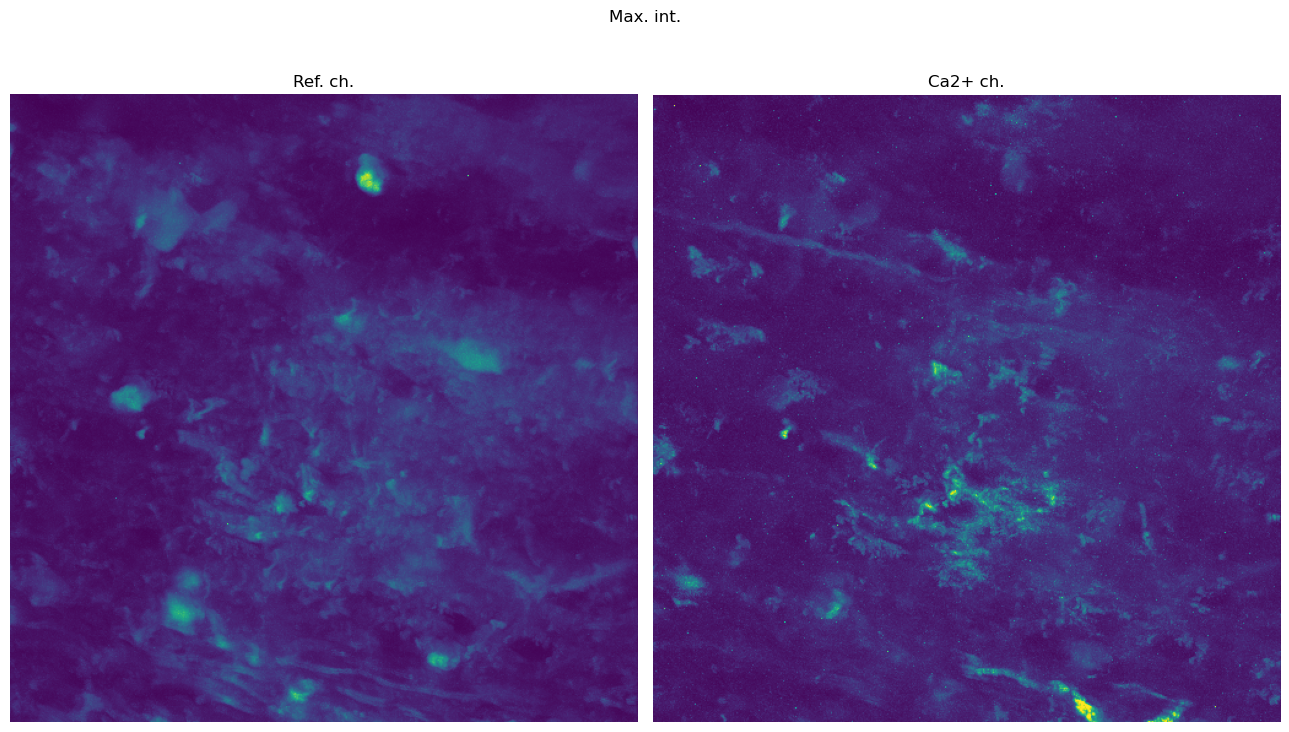

In [4]:
plt.figure(figsize=(13, 8))

ax1 = plt.subplot(121)
ax1.imshow(np.max(ref_series, axis=0))
ax1.set_title('Ref. ch.')
ax1.set_axis_off()

ax2 = plt.subplot(122)
ax2.imshow(np.max(ca_series, axis=0))
ax2.set_title('Ca2+ ch.')
ax2.set_axis_off()

plt.suptitle('Max. int.')
plt.tight_layout()
plt.show()

## Filtering

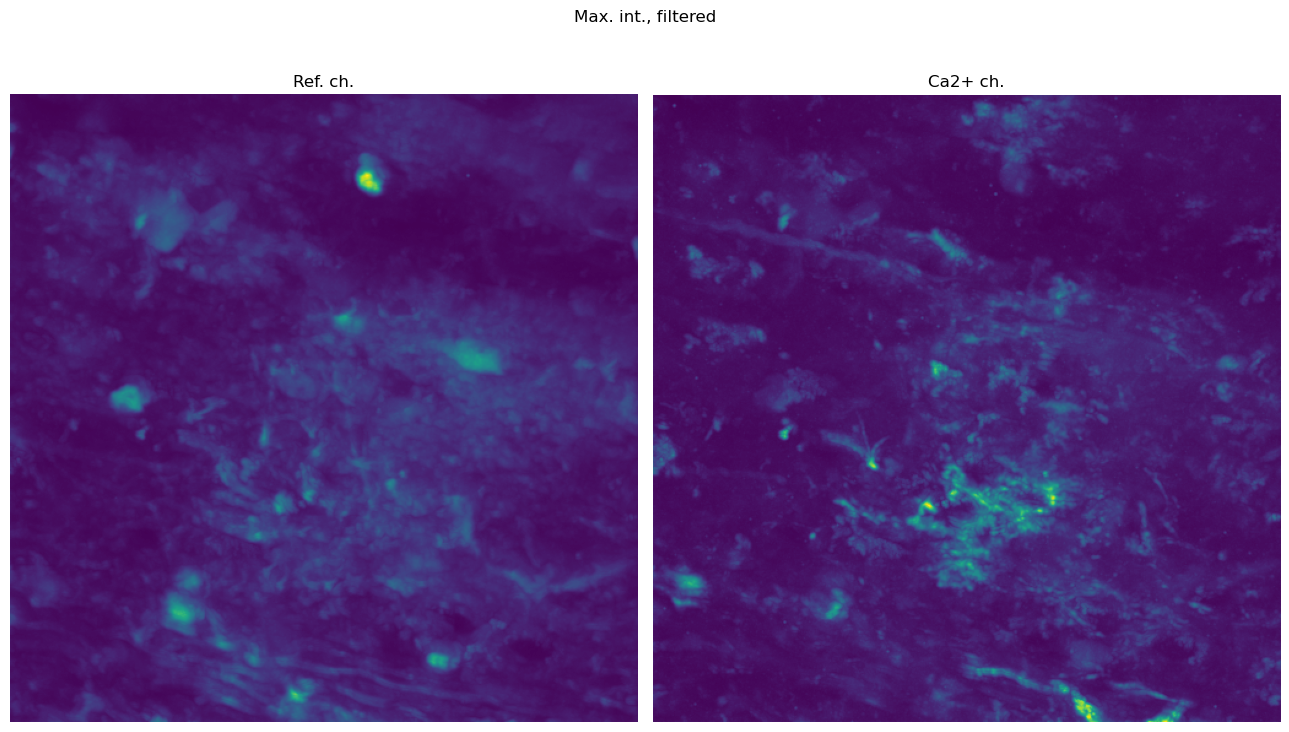

In [5]:
ca_filtered = np.array([filters.gaussian(frame, sigma=1) for frame in ca_series])
ref_filtered = np.array([filters.gaussian(frame, sigma=1) for frame in ref_series])

plt.figure(figsize=(13, 8))

ax1 = plt.subplot(121)
ax1.imshow(np.max(ref_filtered, axis=0))
ax1.set_title('Ref. ch.')
ax1.set_axis_off()

ax2 = plt.subplot(122)
ax2.imshow(np.max(ca_filtered, axis=0))
ax2.set_title('Ca2+ ch.')
ax2.set_axis_off()

plt.suptitle('Max. int., filtered')
plt.tight_layout()
plt.show()

## Full-frame profiles

### Direct avg profile

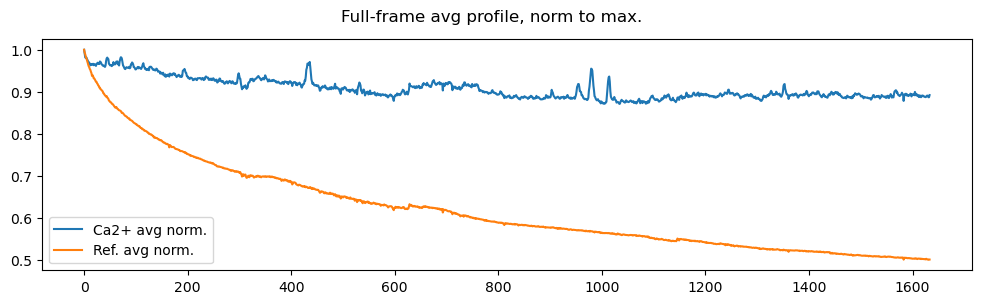

In [6]:
ca_avg_profile = np.mean(ca_filtered, axis=(1,2))
ref_avg_profile = np.average(ref_filtered, axis=(1,2))

# normalization to profile max value
ca_avg_profile_norm = ca_avg_profile / np.max(ca_avg_profile)
ref_avg_profile_norm = ref_avg_profile / np.max(ref_avg_profile)

plt.figure(figsize=(12,3))
plt.plot(time_line, ca_avg_profile_norm, label='Ca2+ avg norm.')
plt.plot(time_line, ref_avg_profile_norm, label='Ref. avg norm.')
plt.legend()
plt.suptitle('Full-frame avg profile, norm to max.')
plt.show()

### Derivative profile

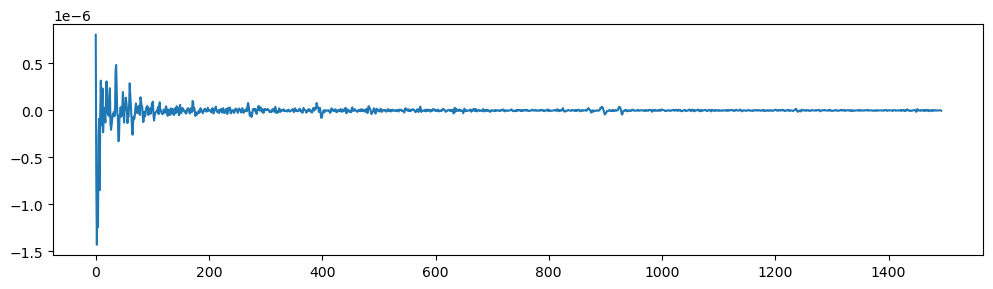

In [8]:

def der(vector):
    """ 1st derivate.
    vector - input data (sweepY)
    dt - discretization frequency (in sec)
    """
    point_der = lambda x_2k, x_1k, x_k1, x_k2, t: (x_2k - 8*x_1k + 8*x_k1 - x_k2)/(12*t)
    return np.array([point_der(vector[i-2], vector[i-1], vector[i+1], vector[i+2], i)
                      for i in range(3,len(vector)-3)])

ca_der_profile = der(ca_avg_profile)

plt.figure(figsize=(12,3))
plt.plot(ca_der_profile, label='Ca2+ avg 1st der.')
plt.show()

## ROIs profiles

### ROIs selection

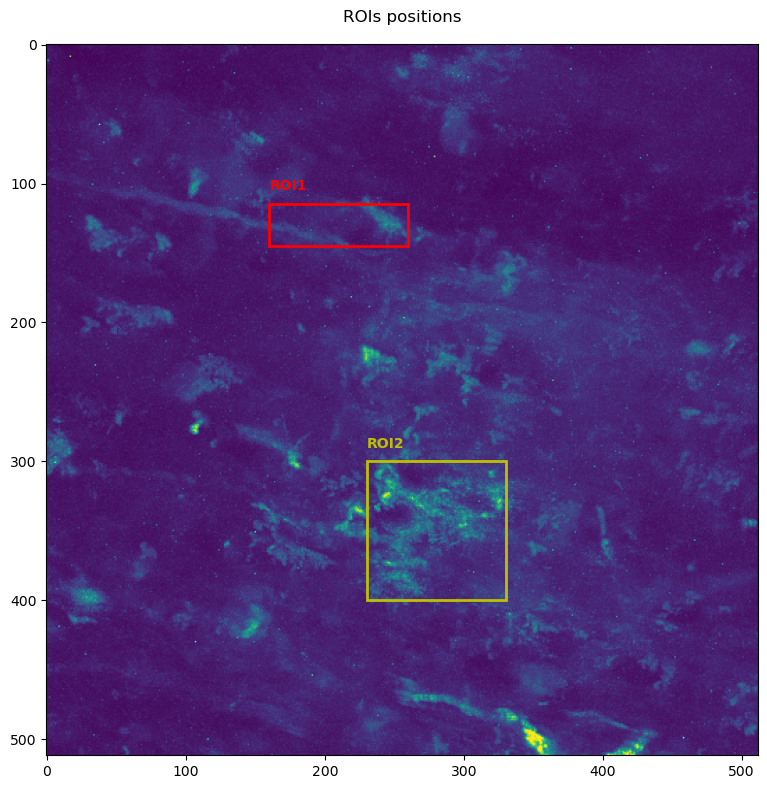

In [9]:
ROI1_param = [160, 115, 100, 30]
ROI2_param = [230, 300, 100, 100]

ROI1 = patches.Rectangle(ROI1_param[0:2], ROI1_param[2], ROI1_param[3],
                         linewidth=2, edgecolor='r', facecolor='none')
ROI2 = patches.Rectangle(ROI2_param[0:2], ROI2_param[2], ROI2_param[3],
                         linewidth=2, edgecolor='y', facecolor='none')

plt.figure(figsize=(13, 8))

ax1 = plt.subplot()
ax1.imshow(np.max(ca_series, axis=0))

ax1.add_patch(ROI1)
ax1.text(ROI1_param[0], ROI1_param[1]-10, 'ROI1', color='r', weight='bold')

ax1.add_patch(ROI2)
ax1.text(ROI2_param[0], ROI2_param[1]-10, 'ROI2', color='y', weight='bold')

# ax1.set_axis_off()

plt.suptitle('ROIs positions')
plt.tight_layout()
plt.show()

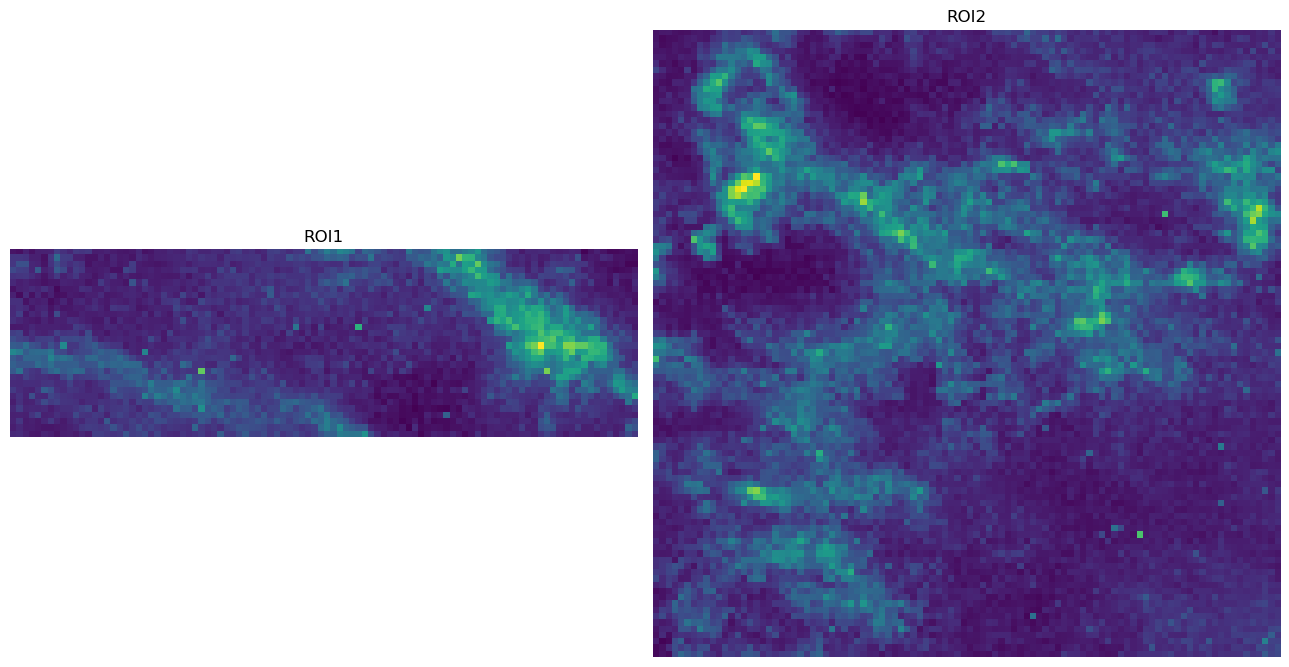

In [10]:
ROI1_series = ca_series[:, ROI1_param[1]:ROI1_param[1]+ROI1_param[3], ROI1_param[0]:ROI1_param[0]+ROI1_param[2]]
ROI2_series = ca_series[:, ROI2_param[1]:ROI2_param[1]+ROI2_param[3], ROI2_param[0]:ROI2_param[0]+ROI2_param[2]]


plt.figure(figsize=(13, 8))

ax1 = plt.subplot(121)
ax1.imshow(np.max(ROI1_series, axis=0))
ax1.set_title('ROI1')
ax1.set_axis_off()

ax2 = plt.subplot(122)
ax2.imshow(np.max(ROI2_series, axis=0))
ax2.set_title('ROI2')
ax2.set_axis_off()

plt.tight_layout()
plt.show()

### ROIs avg profiles

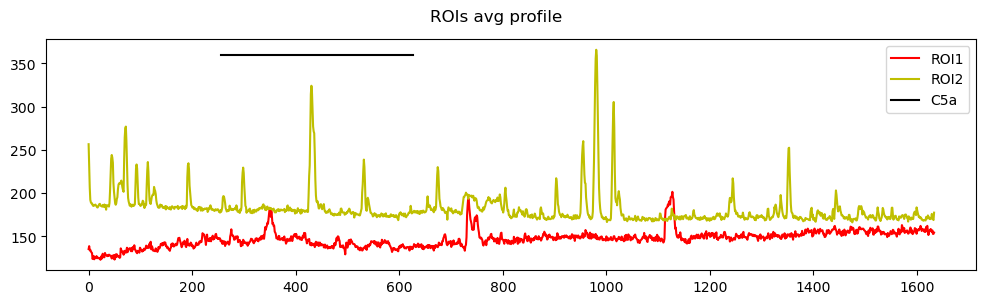

In [11]:
ROI1_avg_profile = np.mean(ROI1_series, axis=(1,2))
ROI2_avg_profile = np.mean(ROI2_series, axis=(1,2))

plt.figure(figsize=(12,3))
plt.plot(time_line, ROI1_avg_profile, label='ROI1', color='r')
plt.plot(time_line, ROI2_avg_profile, label='ROI2', color='y')
plt.plot(app_time, app_y, label='C5a', color='k')
plt.legend()
plt.suptitle('ROIs avg profile')
plt.show()

## ROIs grid profiles

### Profiles building

(3, 3)


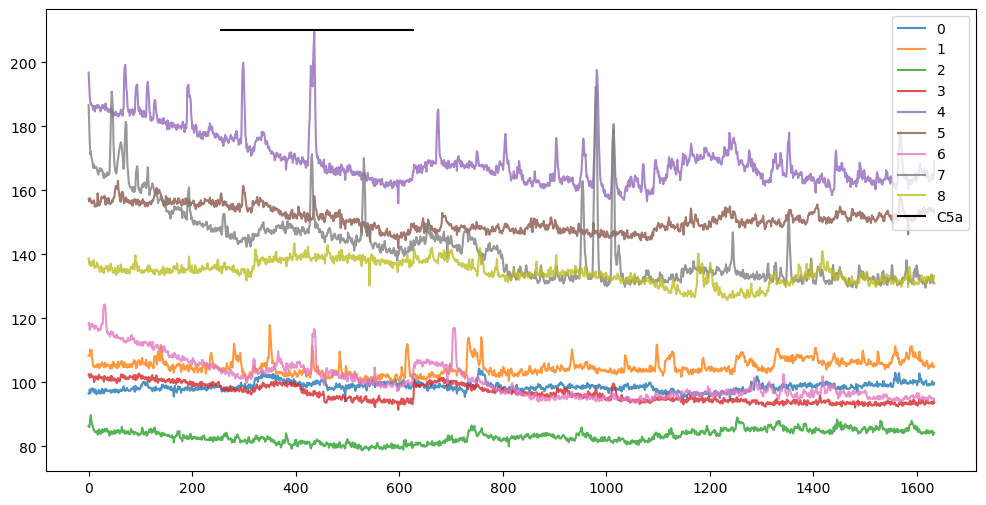

In [12]:
def rebin(arr, new_shape):
    # https://scipython.com/blog/binning-a-2d-array-in-numpy/
    shape = (new_shape[0], arr.shape[0] // new_shape[0],
             new_shape[1], arr.shape[1] // new_shape[1])
    return arr.reshape(shape).mean(-1).mean(1)

ca_series_crop = ca_series[:,:510,:510]
ROI_grid_shape = [3, 3]

ROI_arr = np.array([rebin(frame, ROI_grid_shape) for frame in ca_series_crop])
print(np.shape(ROI_arr)[-2:])


ROI_profile_dic = {}
ROI_n = 0
for i, j in np.ndindex(np.shape(ROI_arr)[-2:]):
    profile = ROI_arr[:, i, j]
    ROI_profile_dic.update({ROI_n:profile})
    ROI_n += 1

plt.figure(figsize=(12, 6))

for ROI_name in ROI_profile_dic.keys():
    plt.plot(time_line, ROI_profile_dic[ROI_name], label=ROI_name, alpha=.8)

plt.plot(app_time, [210] * len(app_time), label='C5a', color='k')
plt.legend()
plt.show()


### Ref. image

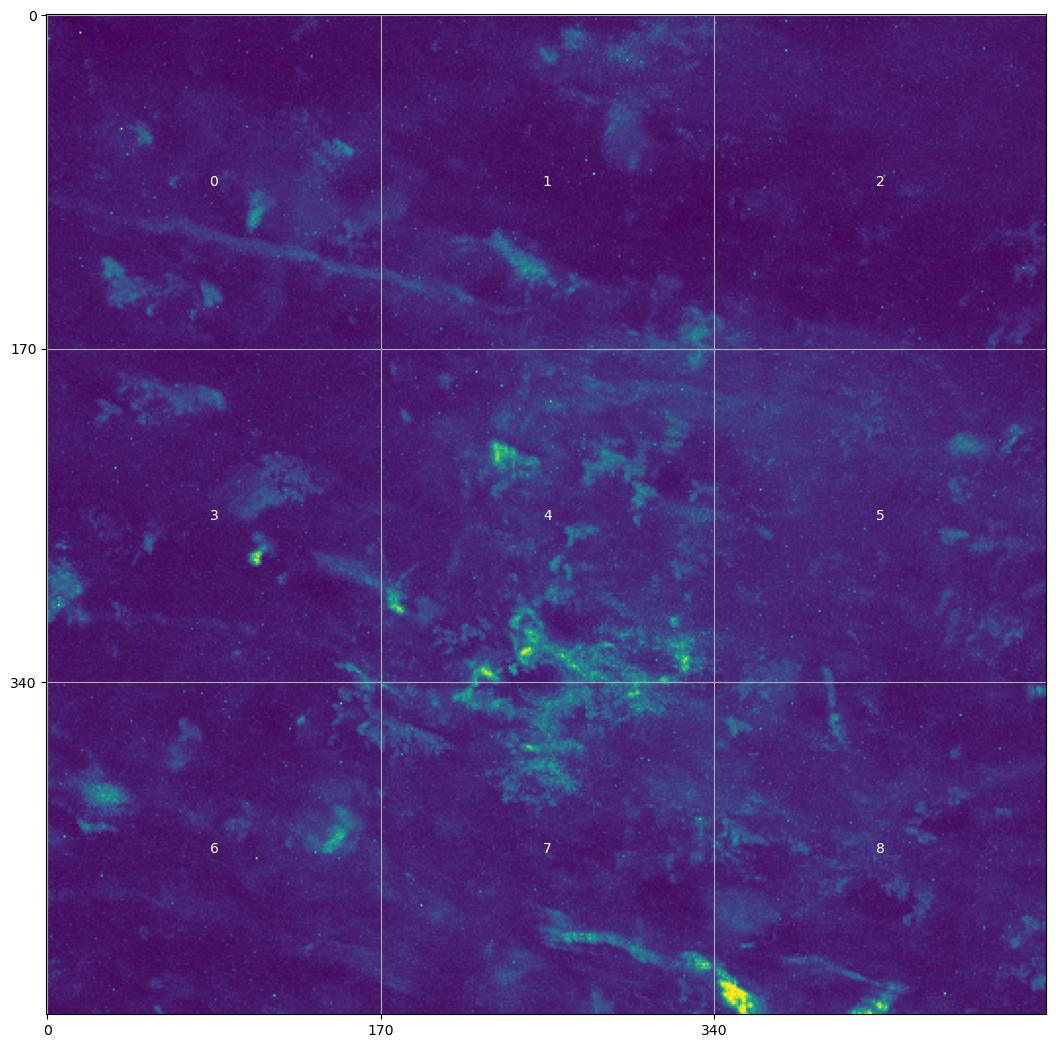

In [13]:
# https://stackoverflow.com/questions/20368413/draw-grid-lines-over-an-image-in-matplotlib
ca_crop_img = np.max(ca_series_crop, axis=0)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

# Remove whitespace from around the image
fig.subplots_adjust(left=0,right=1,bottom=0,top=1)

grid_interval=np.shape(ca_crop_img)[0] // ROI_grid_shape[0]
loc = plticker.MultipleLocator(base=grid_interval)
ax.xaxis.set_major_locator(loc)
ax.yaxis.set_major_locator(loc)

# Add the grid
ax.grid(which='major', axis='both', linestyle='-')
ax.imshow(ca_crop_img)

nx=abs(int(float(ax.get_xlim()[1]-ax.get_xlim()[0])/float(grid_interval)))
ny=abs(int(float(ax.get_ylim()[1]-ax.get_ylim()[0])/float(grid_interval)))

for j in range(ny):
    y=grid_interval/2+j*grid_interval
    for i in range(nx):
        x=grid_interval/2.+float(i)*grid_interval
        ax.text(x,y,'{:d}'.format(i+j*nx),color='w',ha='center',va='center')

plt.show()

### CSV export

In [17]:
ROI_grid_df = pd.DataFrame(data=ROI_profile_dic)
ROI_grid_df['time'] = time_line

# ROI_grid_df.to_csv('ROI_grid.csv')